In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import math
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from fancyimpute import IterativeImputer
from skopt import BayesSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
from statsmodels.imputation.mice import MICEData
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('E Commerce Dataset.csv', encoding='utf-8')
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


--Data Cleaning

In [3]:
df['PreferredPaymentMode'].unique()


array(['Debit Card', 'UPI', 'CC', 'Cash on Delivery', 'E wallet', 'COD',
       'Credit Card'], dtype=object)

In [4]:
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].str.replace('Cash on Delivery','COD')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].str.replace('Credit Card','CC')
df['Complain'] = df['Complain'].astype('object')
df['Churn'] = df['Churn'].astype('object')
df['CityTier'] = df['CityTier'].astype('object')

--Exploratory Data Analysis(EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   object 
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   object 
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [6]:
#print summary statistics of the data including the categorical columns
df.describe(include='all')

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.0,5366.000000,5630,5630.0,5379.000000,5630,5630,5375.000000,5630.000000,5630,5630.000000,5630,5630.000000,5630.0,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
unique,NaN,2.0,NaN,3,3.0,NaN,5,2,NaN,NaN,6,NaN,3,NaN,2.0,NaN,NaN,NaN,NaN,NaN
top,NaN,0.0,NaN,Mobile Phone,1.0,NaN,Debit Card,Male,NaN,NaN,Laptop & Accessory,NaN,Married,NaN,0.0,NaN,NaN,NaN,NaN,NaN
freq,NaN,4682.0,NaN,2765,3666.0,NaN,2314,3384,NaN,NaN,2050,NaN,2986,NaN,4026.0,NaN,NaN,NaN,NaN,NaN
mean,52815.500000,NaN,10.189899,NaN,NaN,15.639896,NaN,NaN,2.931535,3.688988,NaN,3.066785,NaN,4.214032,NaN,15.707922,1.751023,3.008004,4.543491,177.221492
std,1625.385339,NaN,8.557241,NaN,NaN,8.531475,NaN,NaN,0.721926,1.023999,NaN,1.380194,NaN,2.583586,NaN,3.675485,1.894621,2.939680,3.654433,49.193869
min,50001.000000,NaN,0.000000,NaN,NaN,5.000000,NaN,NaN,0.000000,1.000000,NaN,1.000000,NaN,1.000000,NaN,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51408.250000,NaN,2.000000,NaN,NaN,9.000000,NaN,NaN,2.000000,3.000000,NaN,2.000000,NaN,2.000000,NaN,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,NaN,9.000000,NaN,NaN,14.000000,NaN,NaN,3.000000,4.000000,NaN,3.000000,NaN,3.000000,NaN,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,NaN,16.000000,NaN,NaN,20.000000,NaN,NaN,3.000000,4.000000,NaN,4.000000,NaN,6.000000,NaN,18.000000,2.000000,3.000000,7.000000,196.000000


In [7]:
cat=[]
num=[]
for i in df.columns:
  if df[i].dtype=='object':
    cat.append(i)
  else:
    num.append(i)
print('cat = ',cat)
print('num = ',num)

cat =  ['Churn', 'PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus', 'Complain']
num =  ['CustomerID', 'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']


In [8]:
#Average portion of churned customers
df.Churn.mean()

0.16838365896980462

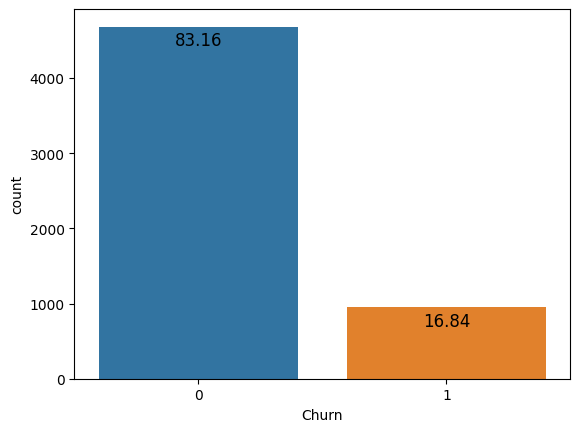

In [9]:
#count the number of customers in the churn and not churn class
ax = sns.countplot(x='Churn', data=df)
for a in ax.patches:
    ax.annotate(format((a.get_height()/5630)*100,'.2f'), (a.get_x() + a.get_width()/2., a.get_height()),\
                ha='center',va='center',size=12,xytext=(0, -10),textcoords='offset points')
plt.show()

In [10]:
df[cat].describe().T

,count,unique,top,freq
Churn,5630,2,0,4682
PreferredLoginDevice,5630,3,Mobile Phone,2765
CityTier,5630,3,1,3666
PreferredPaymentMode,5630,5,Debit Card,2314
Gender,5630,2,Male,3384
PreferedOrderCat,5630,6,Laptop & Accessory,2050
MaritalStatus,5630,3,Married,2986
Complain,5630,2,0,4026


In [11]:
for i in cat:
    print(i)
    print()
    print(df[i].value_counts())
    print()
    print()

Churn

Churn
0    4682
1     948
Name: count, dtype: int64


PreferredLoginDevice

PreferredLoginDevice
Mobile Phone    2765
Computer        1634
Phone           1231
Name: count, dtype: int64


CityTier

CityTier
1    3666
3    1722
2     242
Name: count, dtype: int64


PreferredPaymentMode

PreferredPaymentMode
Debit Card    2314
CC            1774
E wallet       614
COD            514
UPI            414
Name: count, dtype: int64


Gender

Gender
Male      3384
Female    2246
Name: count, dtype: int64


PreferedOrderCat

PreferedOrderCat
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: count, dtype: int64


MaritalStatus

MaritalStatus
Married     2986
Single      1796
Divorced     848
Name: count, dtype: int64


Complain

Complain
0    4026
1    1604
Name: count, dtype: int64




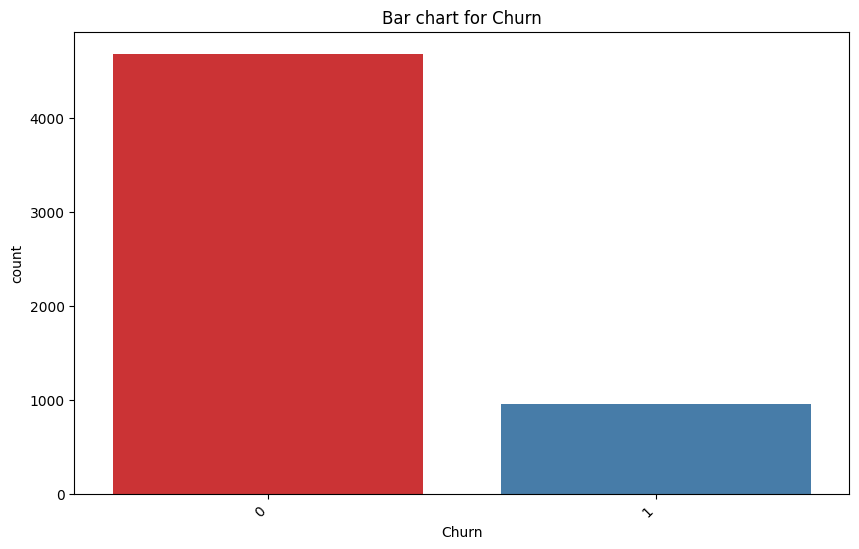

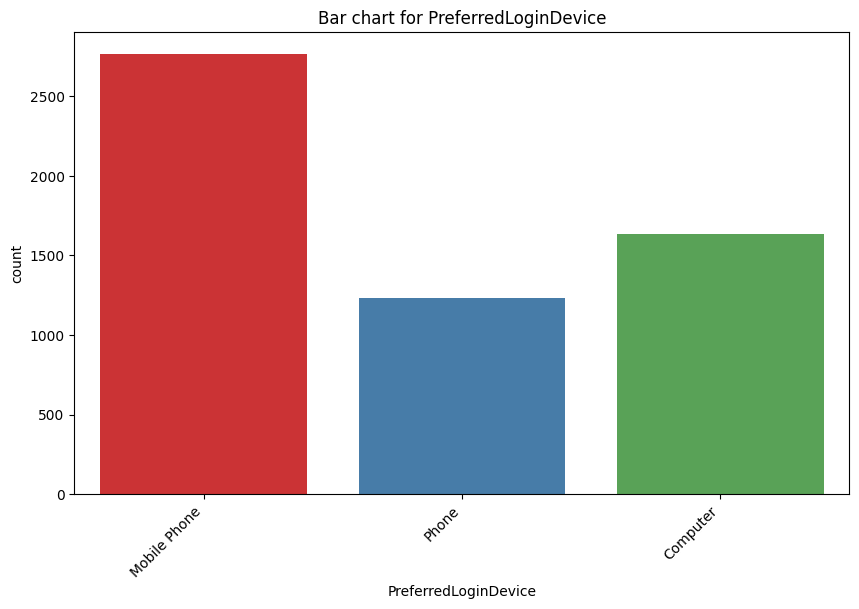

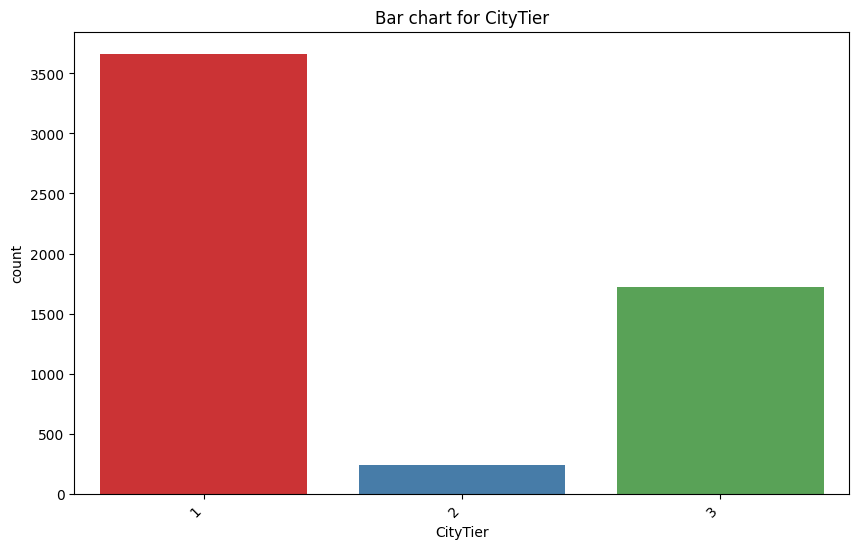

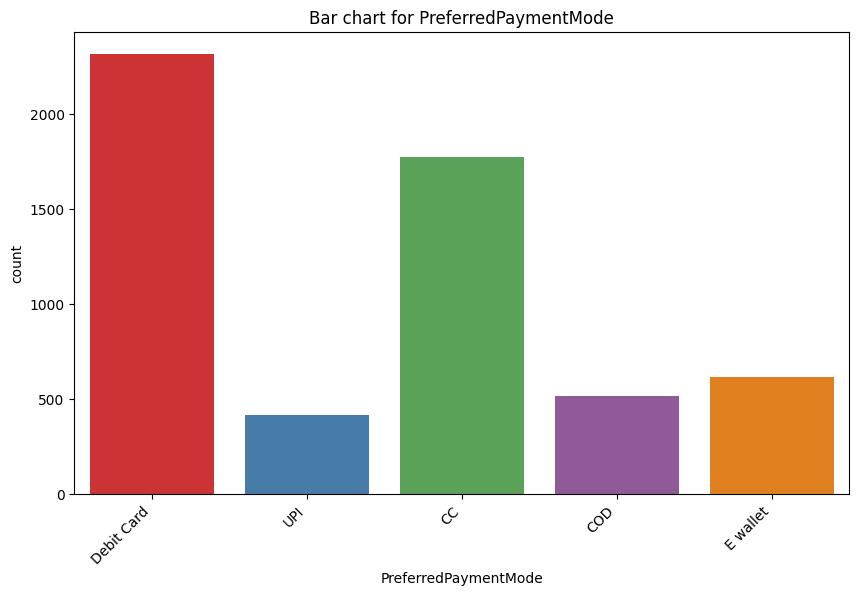

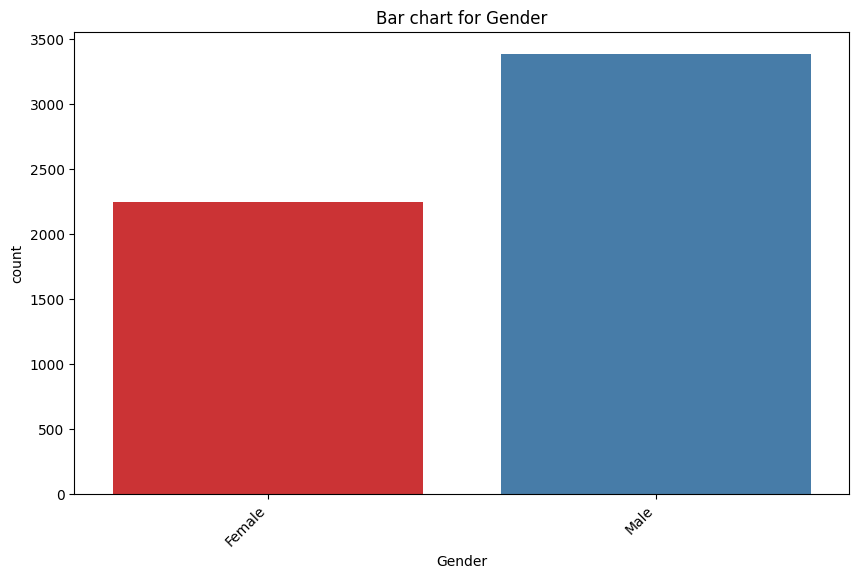

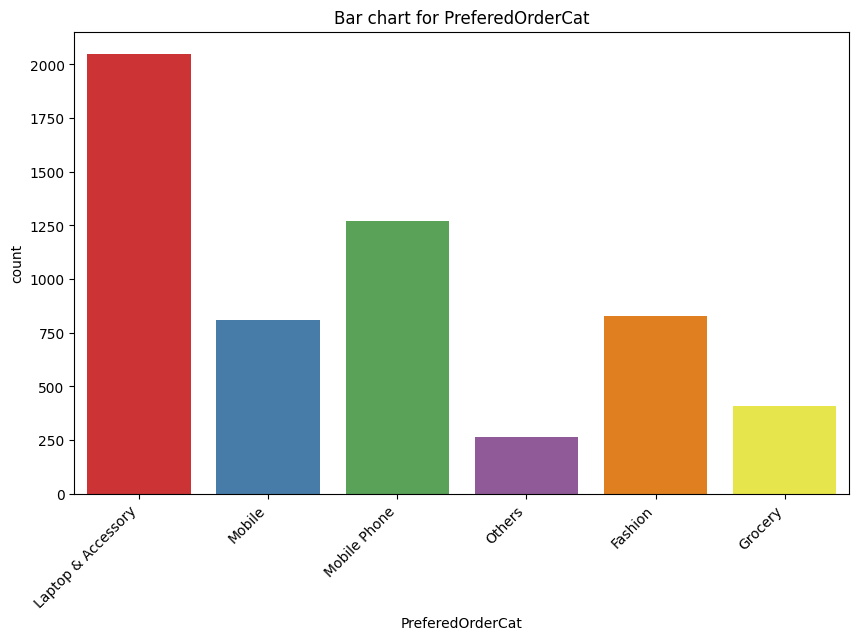

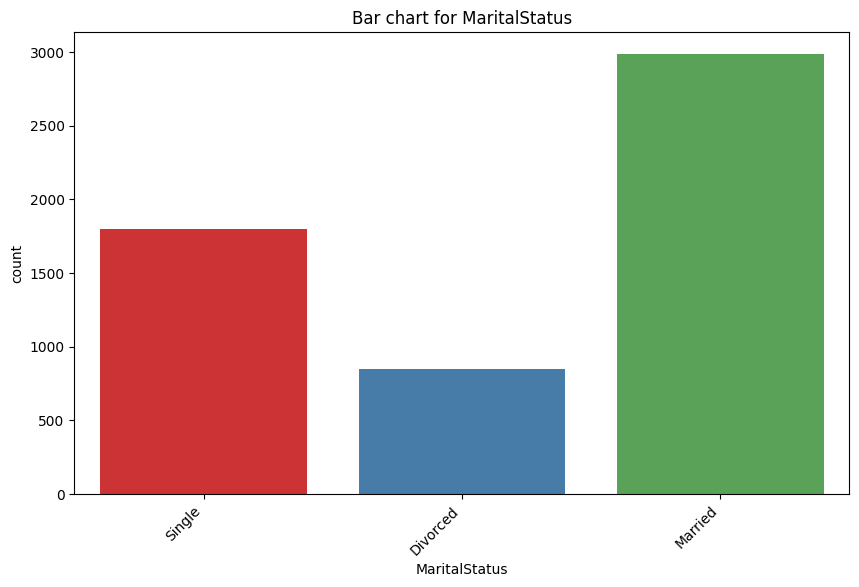

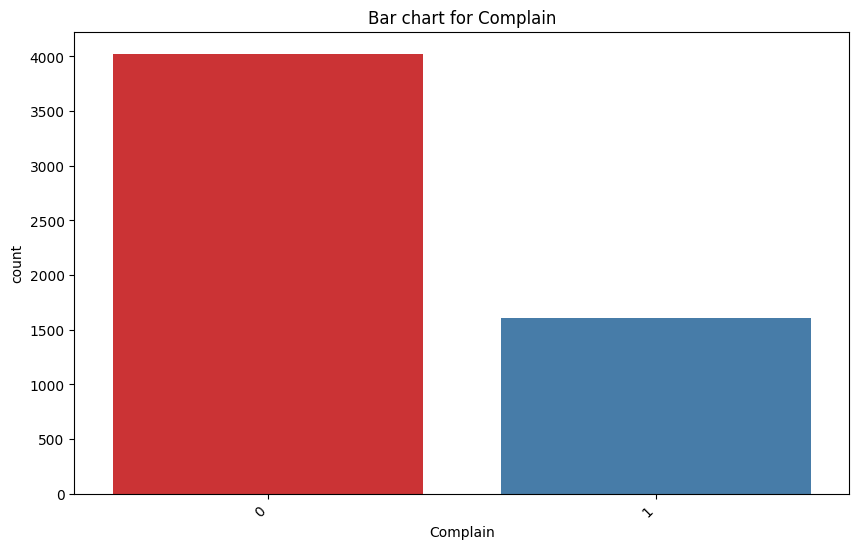

In [12]:
for col in cat:
    plt.figure(figsize=(10,6))
    chart = sns.countplot(
        data=df,
        x=col,
        palette='Set1'
    )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f'Bar chart for {col}')
    plt.show()

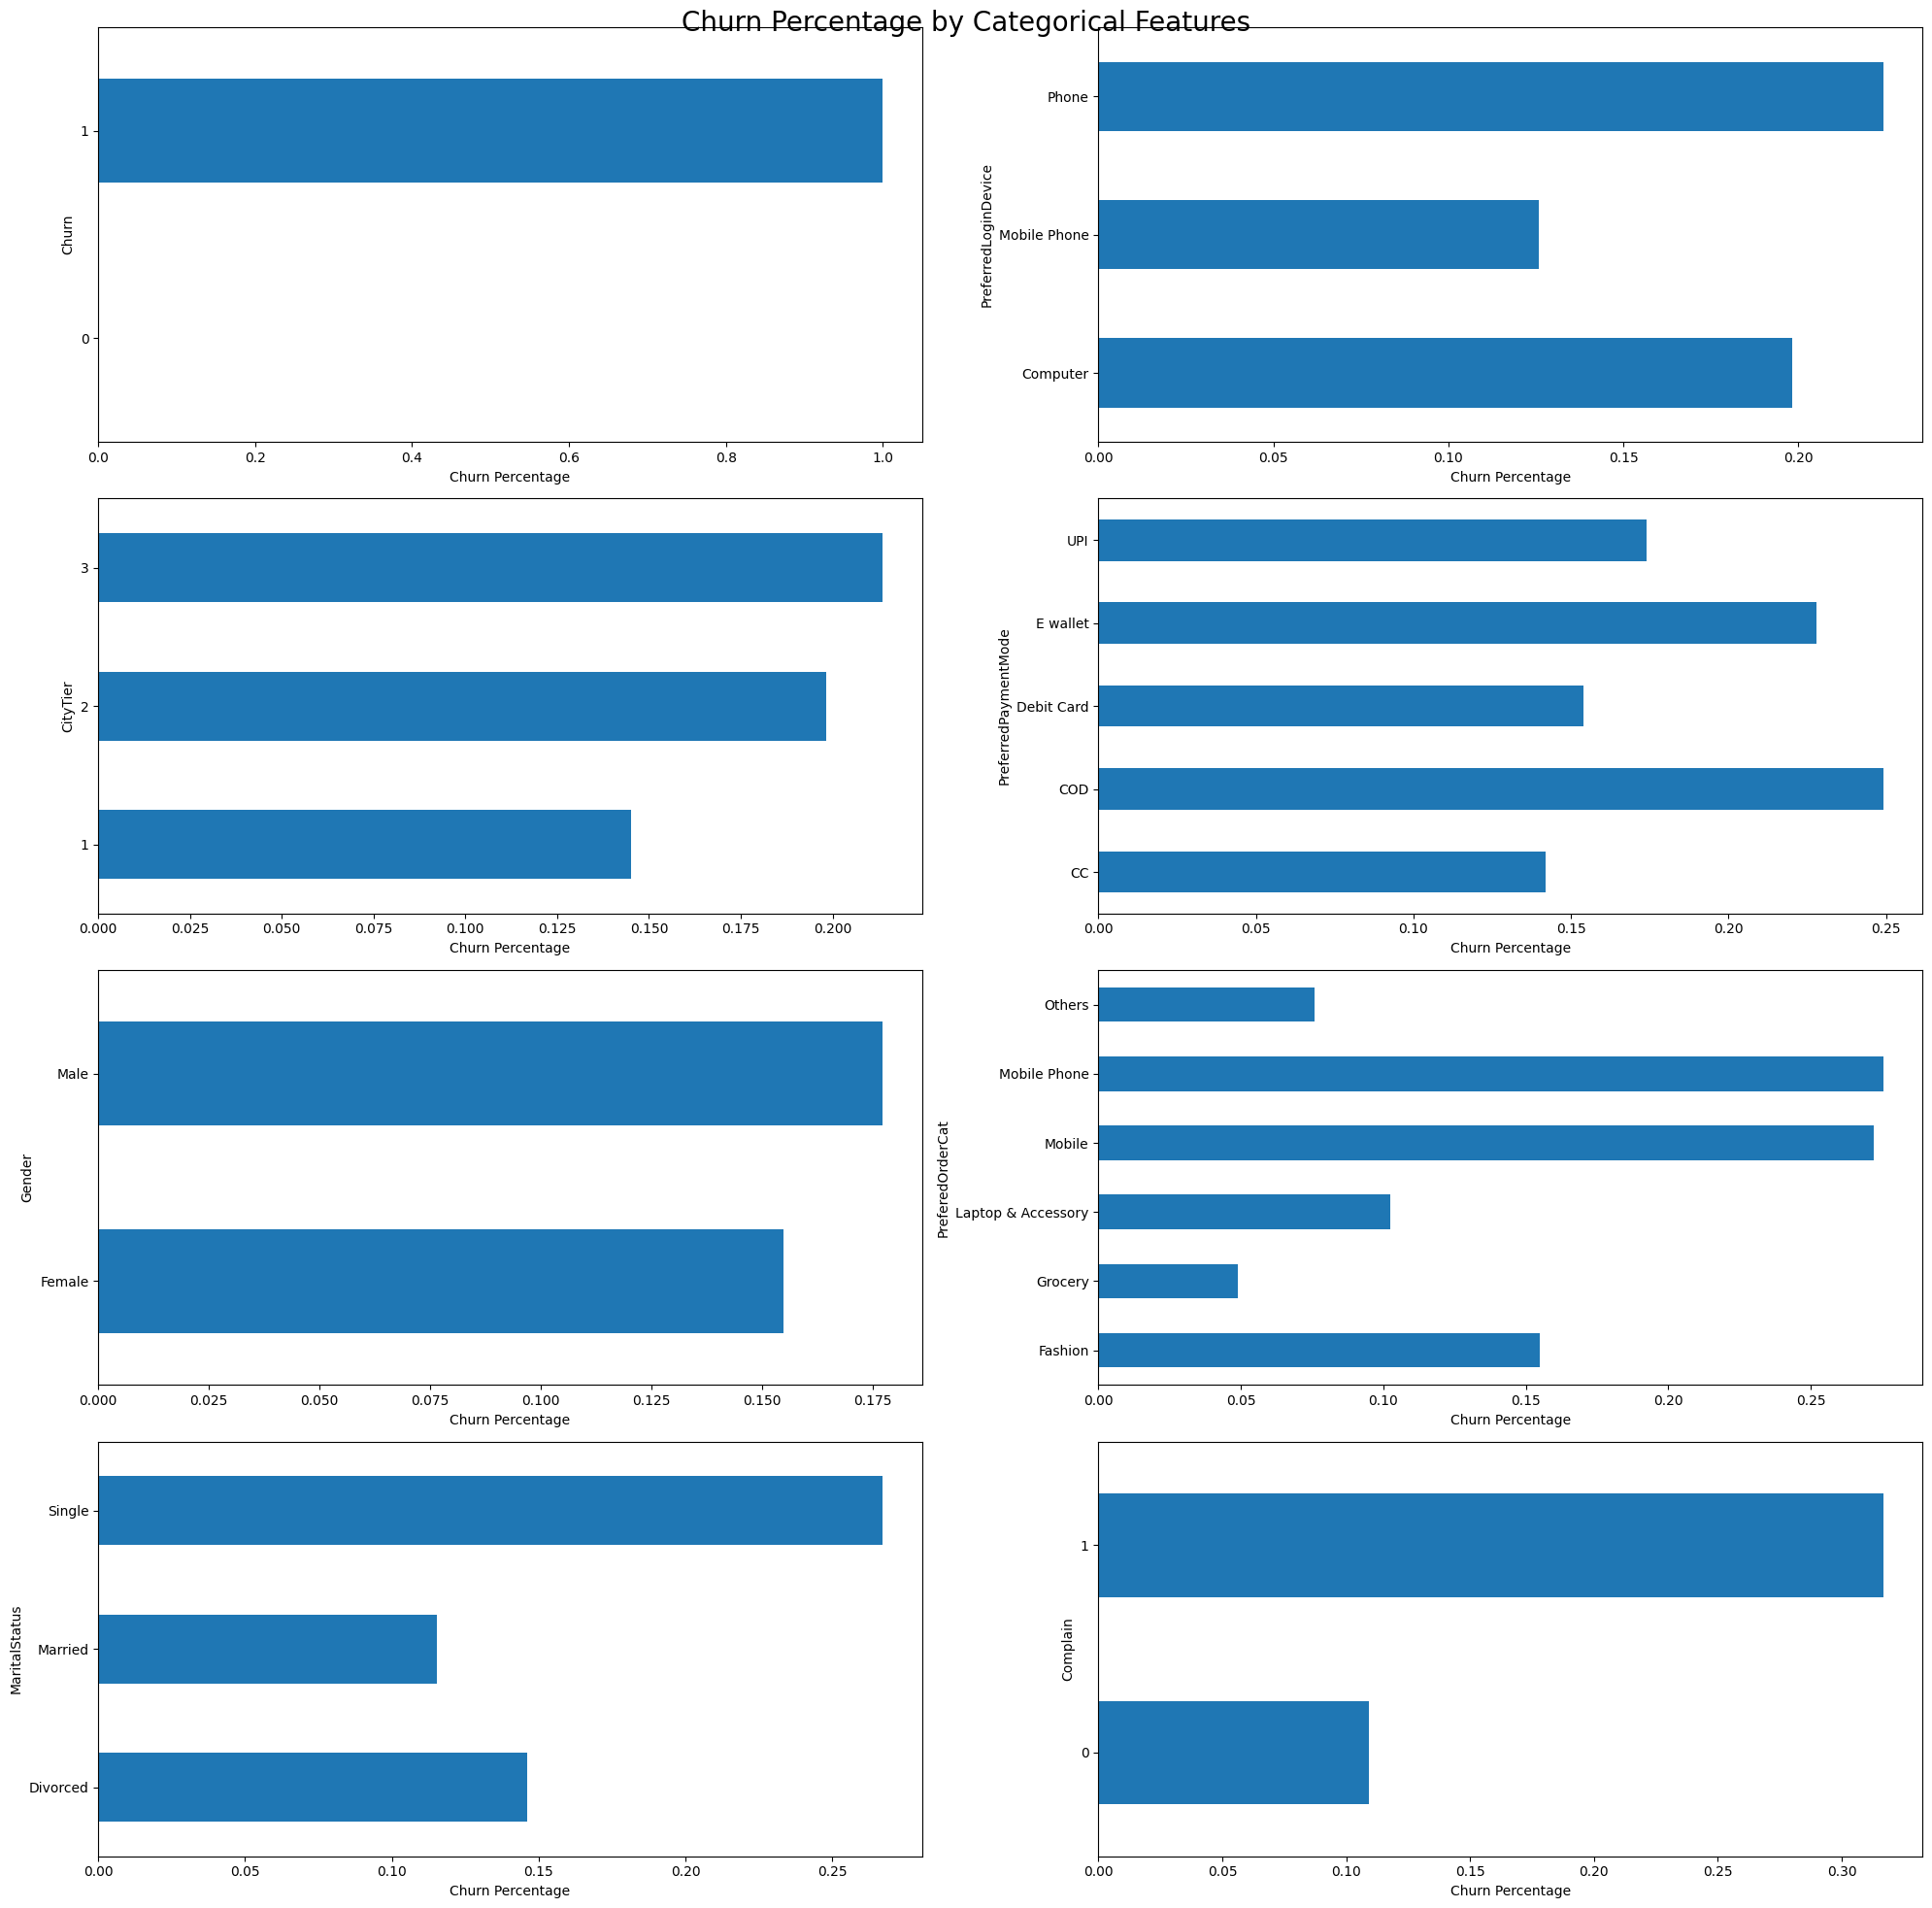

In [13]:
# Visualize churn percentage by categorical features (may need to covert complain into binary cat and add in)
N = len(cat) # number of categorical features
cols = 2 # number of columns you want in your plot grid
rows = math.ceil(N / cols) # calculate the number of rows needed

fig, ax = plt.subplots(rows, cols, figsize=(20, rows*5))
fig.suptitle('Churn Percentage by Categorical Features', fontsize=20)
ax = ax.flatten() # flatten the array so you can iterate over it

for idx, c in enumerate(cat):
    df.groupby(c).Churn.mean().plot.barh(ax=ax[idx])
    ax[idx].set_xlabel('Churn Percentage')

# if there are less categorical features than subplots, remove the extra ones
if N < len(ax):
    for i in range(N, len(ax)):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

In [14]:
df[num].describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,5630.0,52815.500000,1625.385339,50001.0,51408.25,52815.5,54222.75,55630.0
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.0,16.00,61.0
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.0,20.00,127.0
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.0,3.00,5.0
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.0,4.00,6.0
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.0,4.00,5.0
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.0,6.00,22.0
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,13.00,15.0,18.00,26.0
CouponUsed,5374.0,1.751023,1.894621,0.0,1.00,1.0,2.00,16.0
OrderCount,5372.0,3.008004,2.939680,1.0,1.00,2.0,3.00,16.0


array([[<Axes: title={'center': 'CustomerID'}>,
        <Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'WarehouseToHome'}>],
       [<Axes: title={'center': 'HourSpendOnApp'}>,
        <Axes: title={'center': 'NumberOfDeviceRegistered'}>,
        <Axes: title={'center': 'SatisfactionScore'}>],
       [<Axes: title={'center': 'NumberOfAddress'}>,
        <Axes: title={'center': 'OrderAmountHikeFromlastYear'}>,
        <Axes: title={'center': 'CouponUsed'}>],
       [<Axes: title={'center': 'OrderCount'}>,
        <Axes: title={'center': 'DaySinceLastOrder'}>,
        <Axes: title={'center': 'CashbackAmount'}>]], dtype=object)

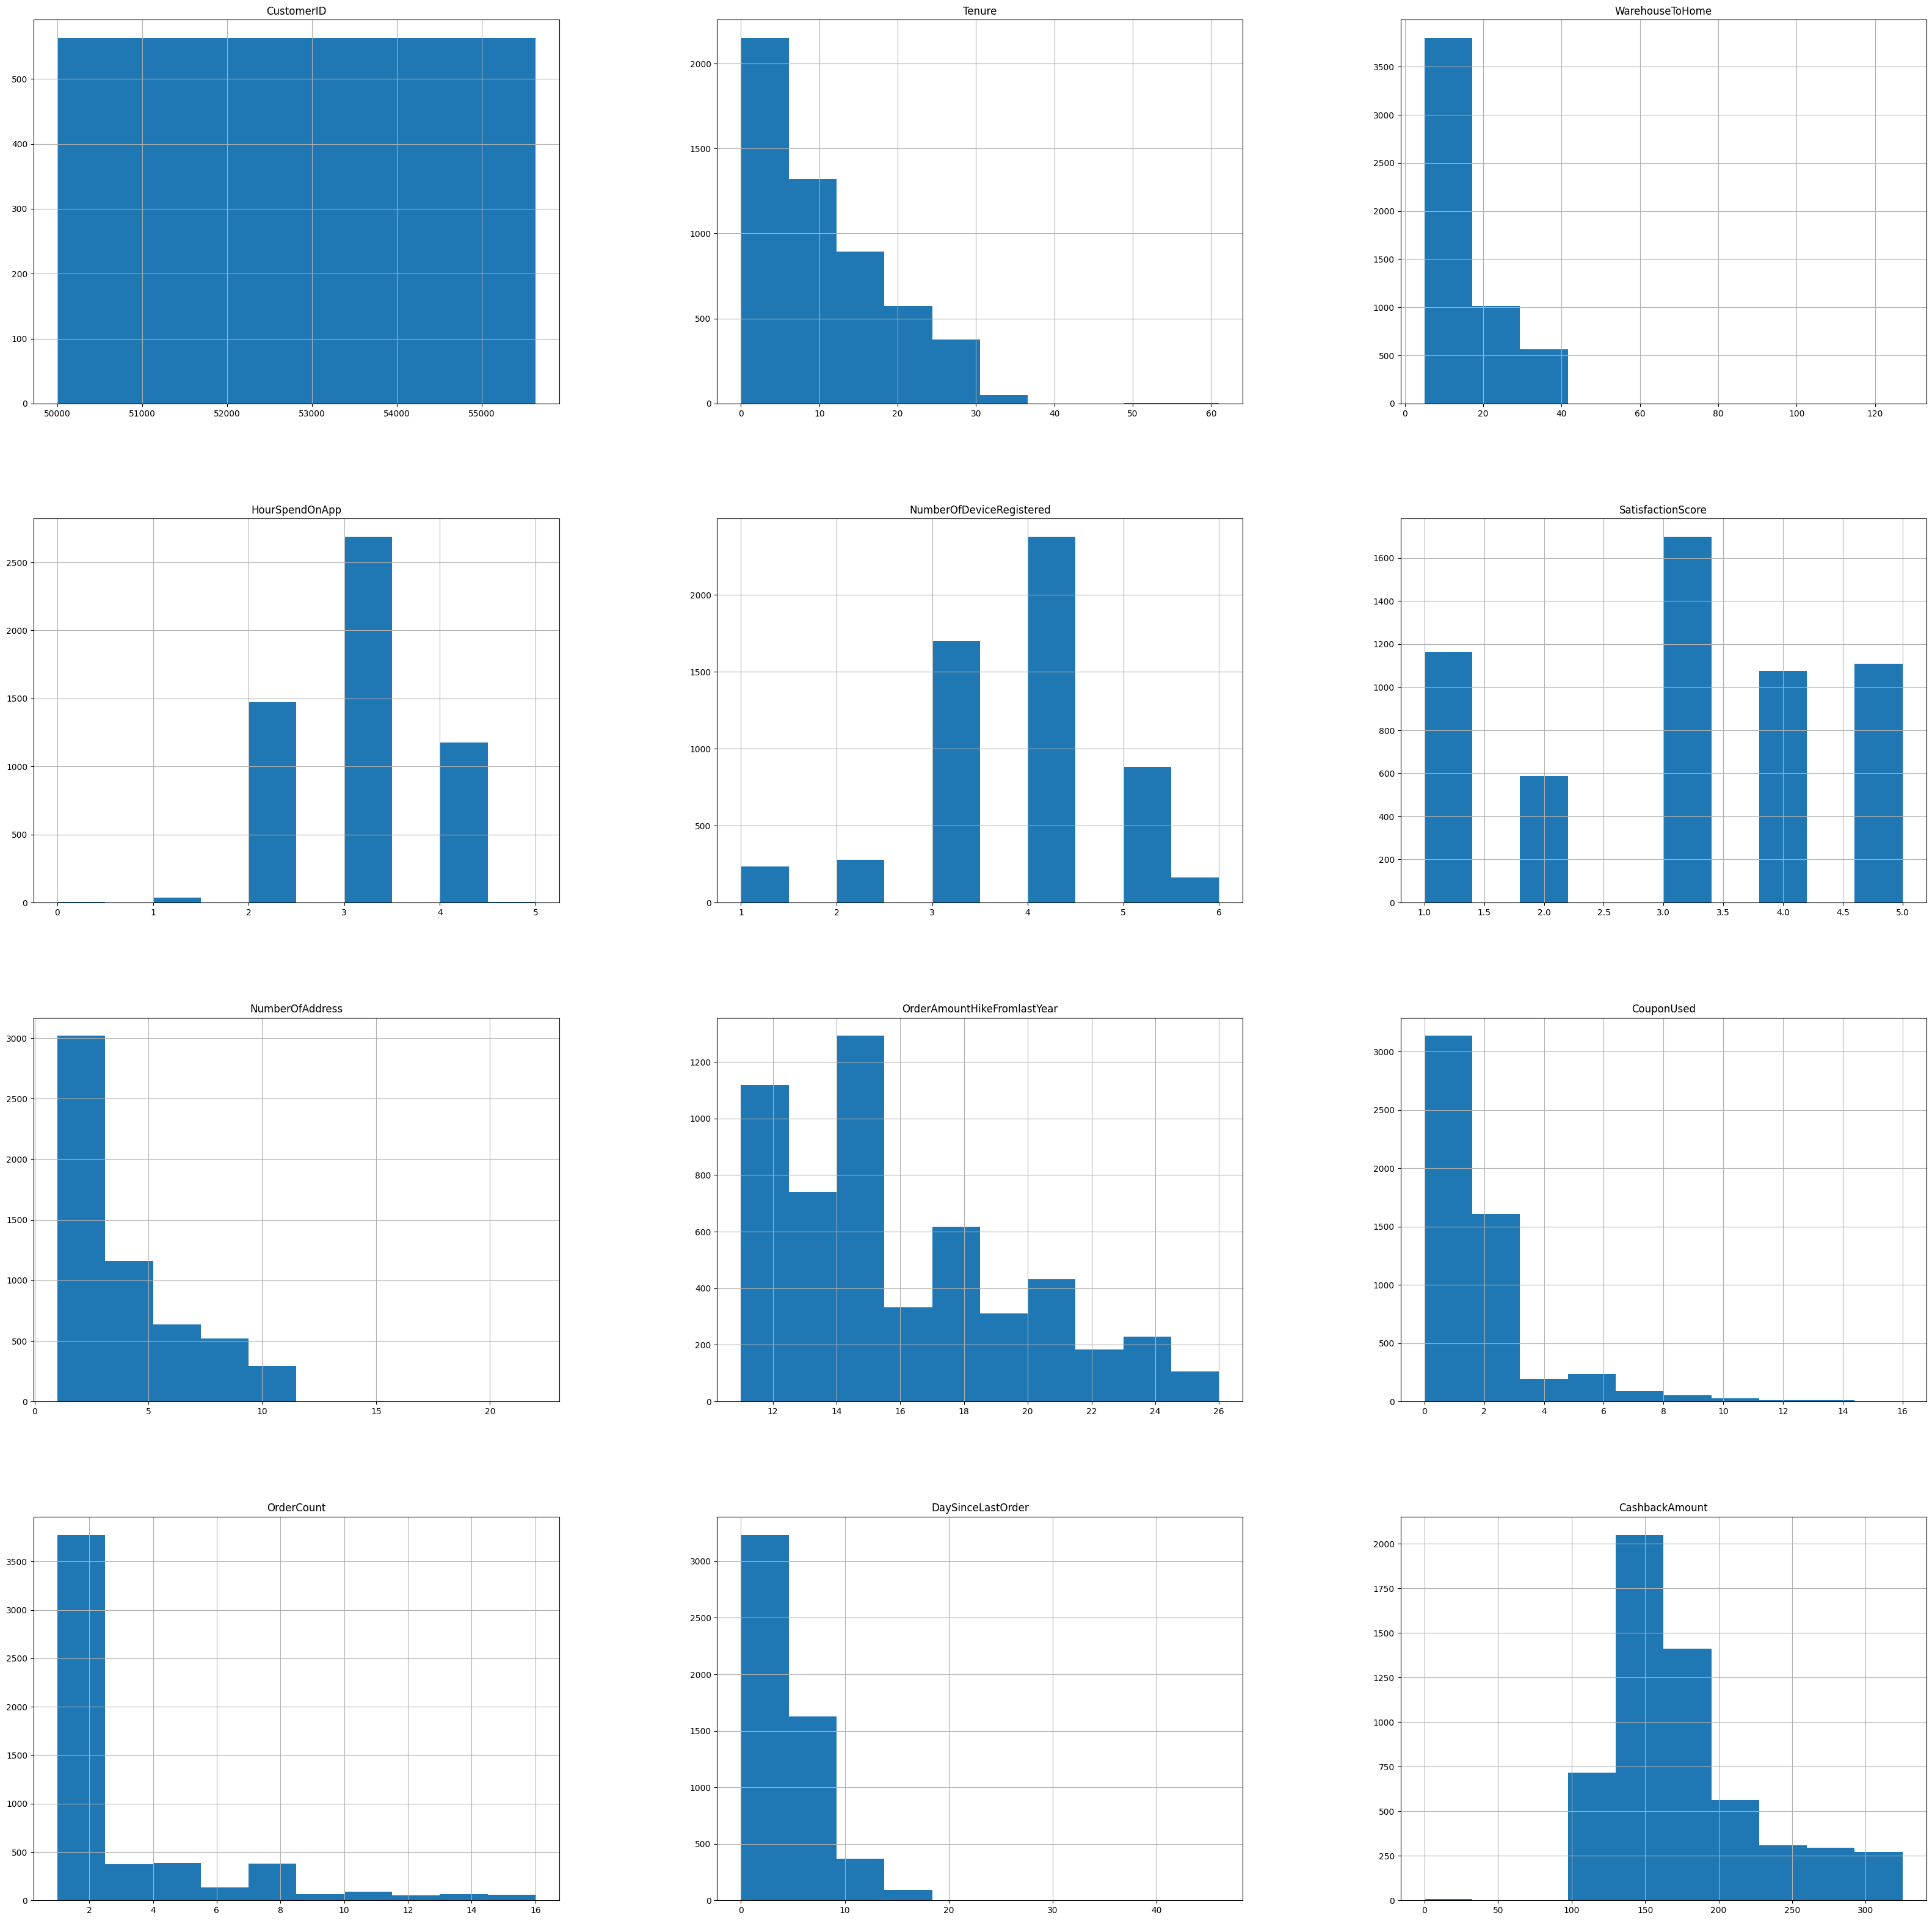

In [15]:
df[num].hist(figsize=(40,40))

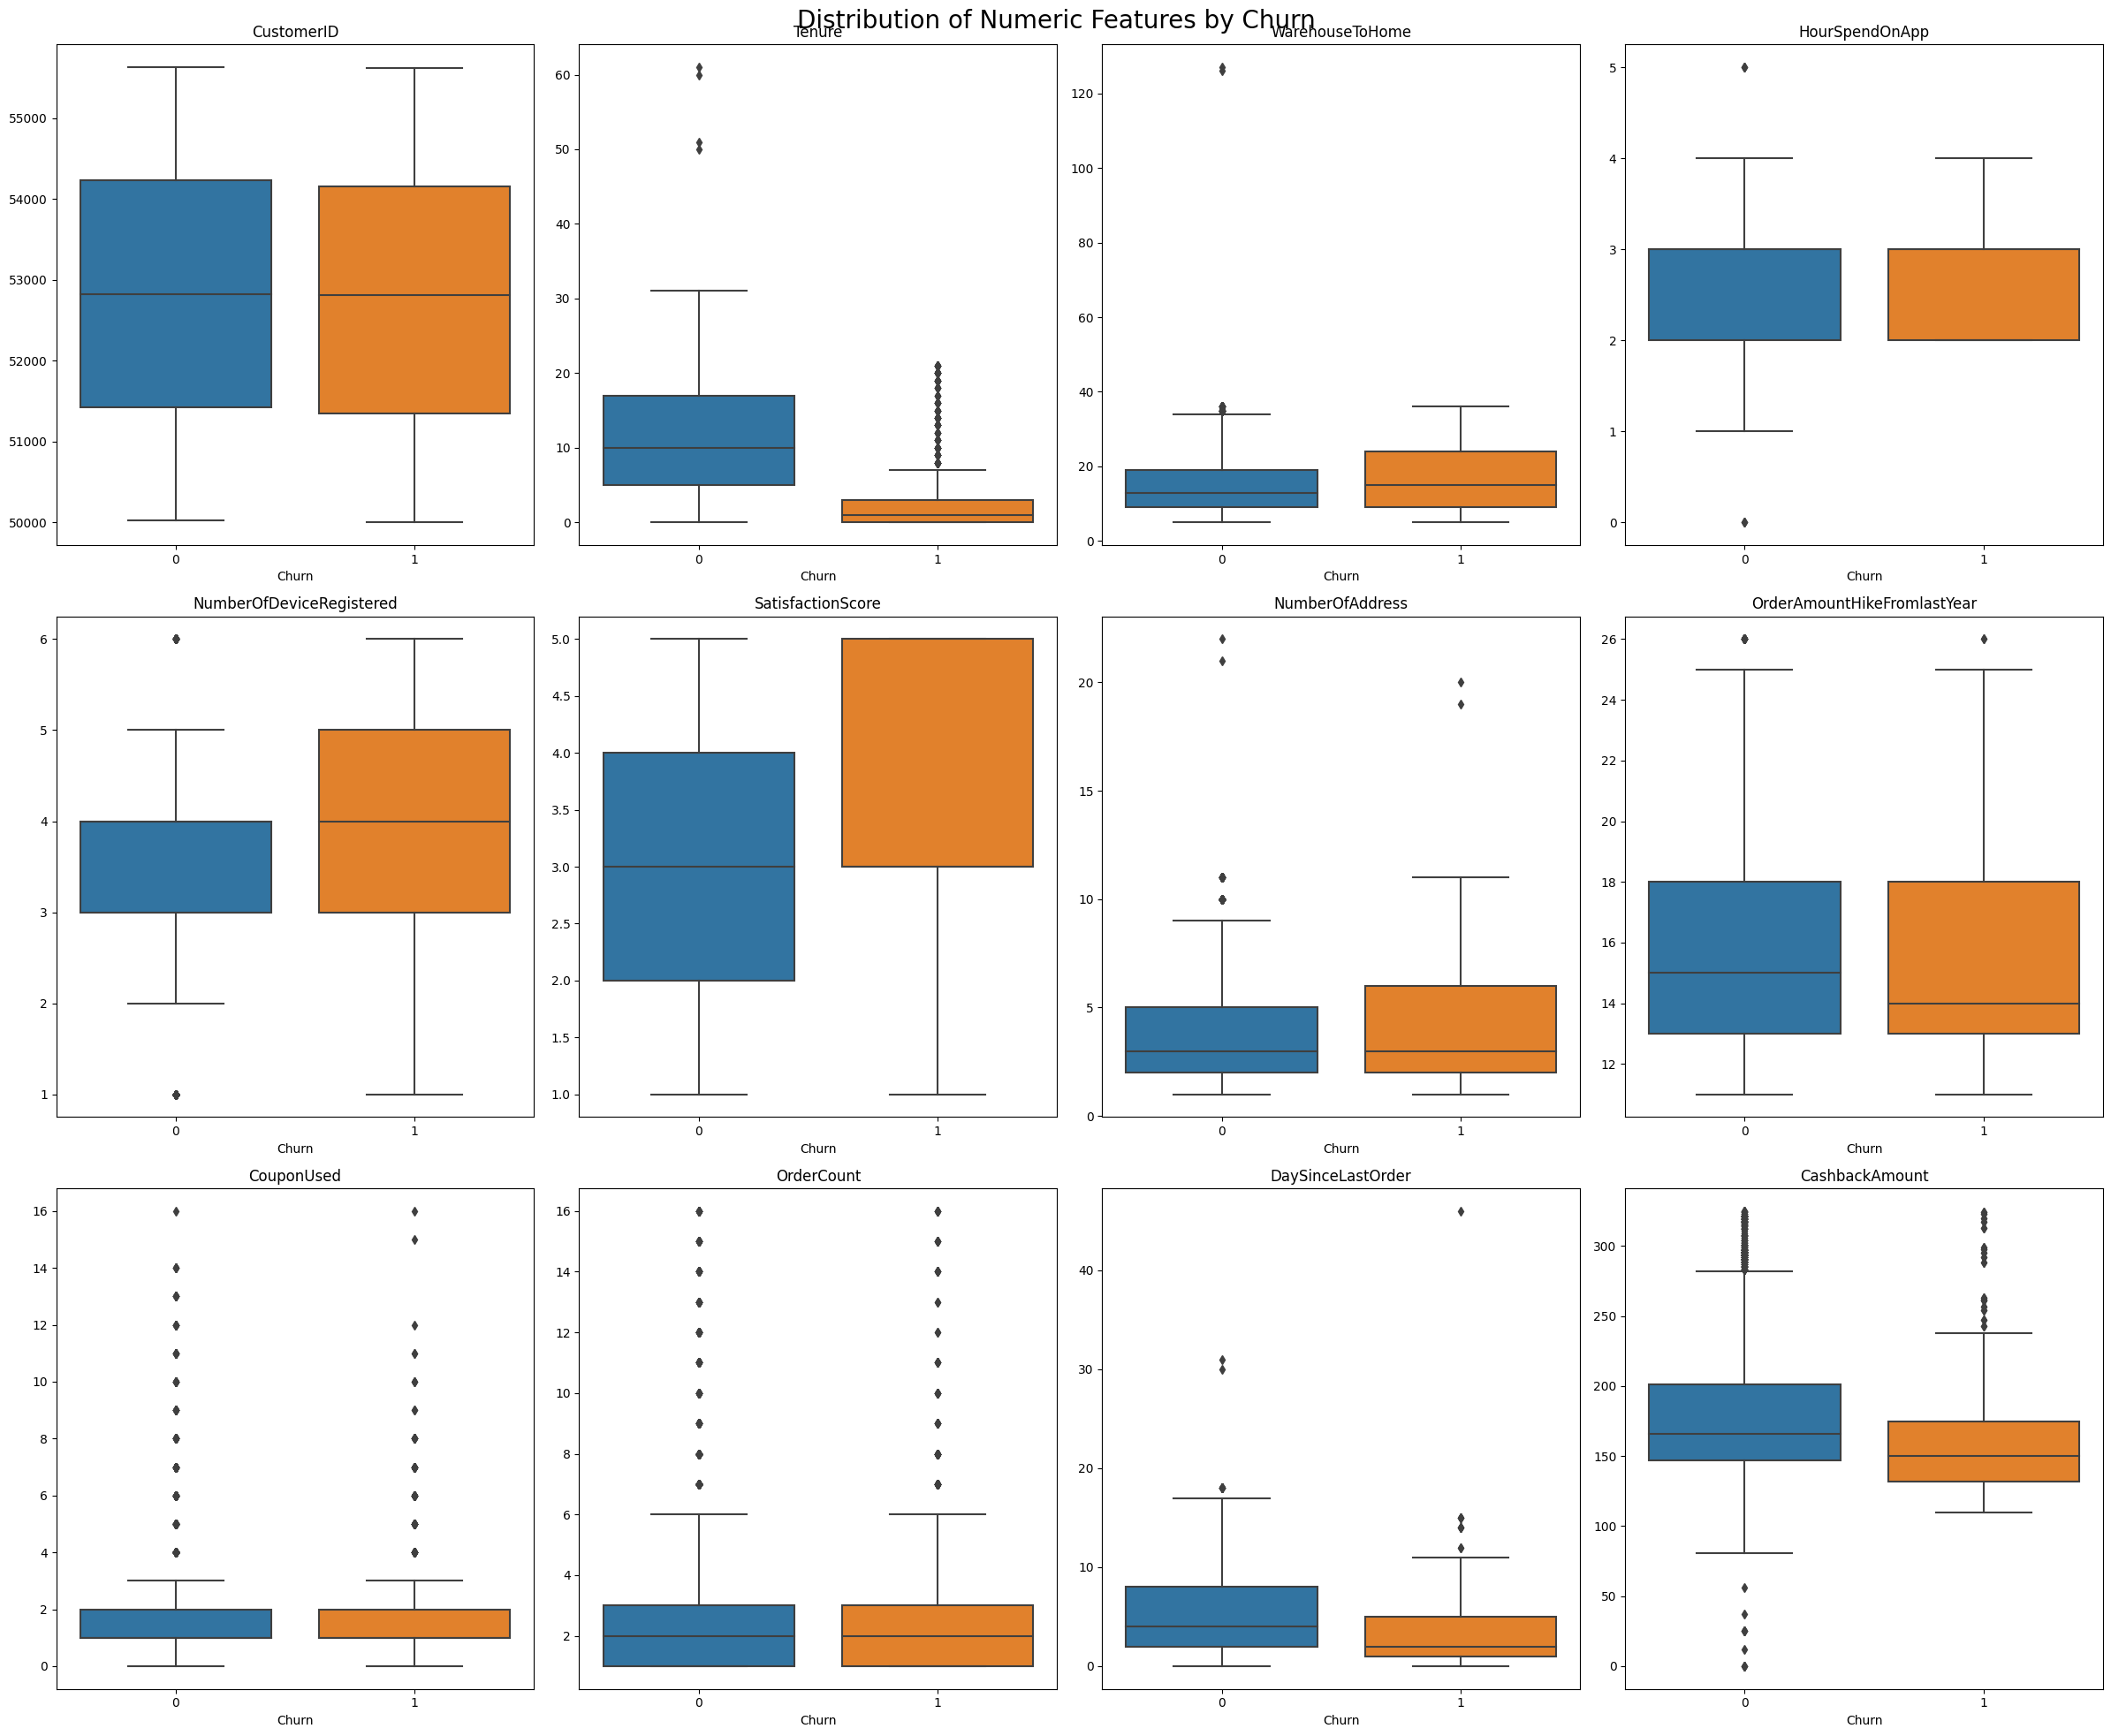

In [16]:
# Visualize Distribution of Numeric Features by Churn
n = len(num)
cols = int(np.ceil(np.sqrt(n)))
rows = int(np.ceil(n / cols))

fig, ax = plt.subplots(rows, cols, figsize=(24, 20))
fig.suptitle('Distribution of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()  # Flattening the array of axes

for idx, c in enumerate(num):
    df_t = df[df[c].notnull()].copy()
    ax[idx].set_title(c) 
    sns.boxplot(x='Churn', y=c, data=df_t, ax=ax[idx])
    ax[idx].set_ylabel('')

# Remove extra subplots
if n < len(ax):
    for i in range(n, len(ax)):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

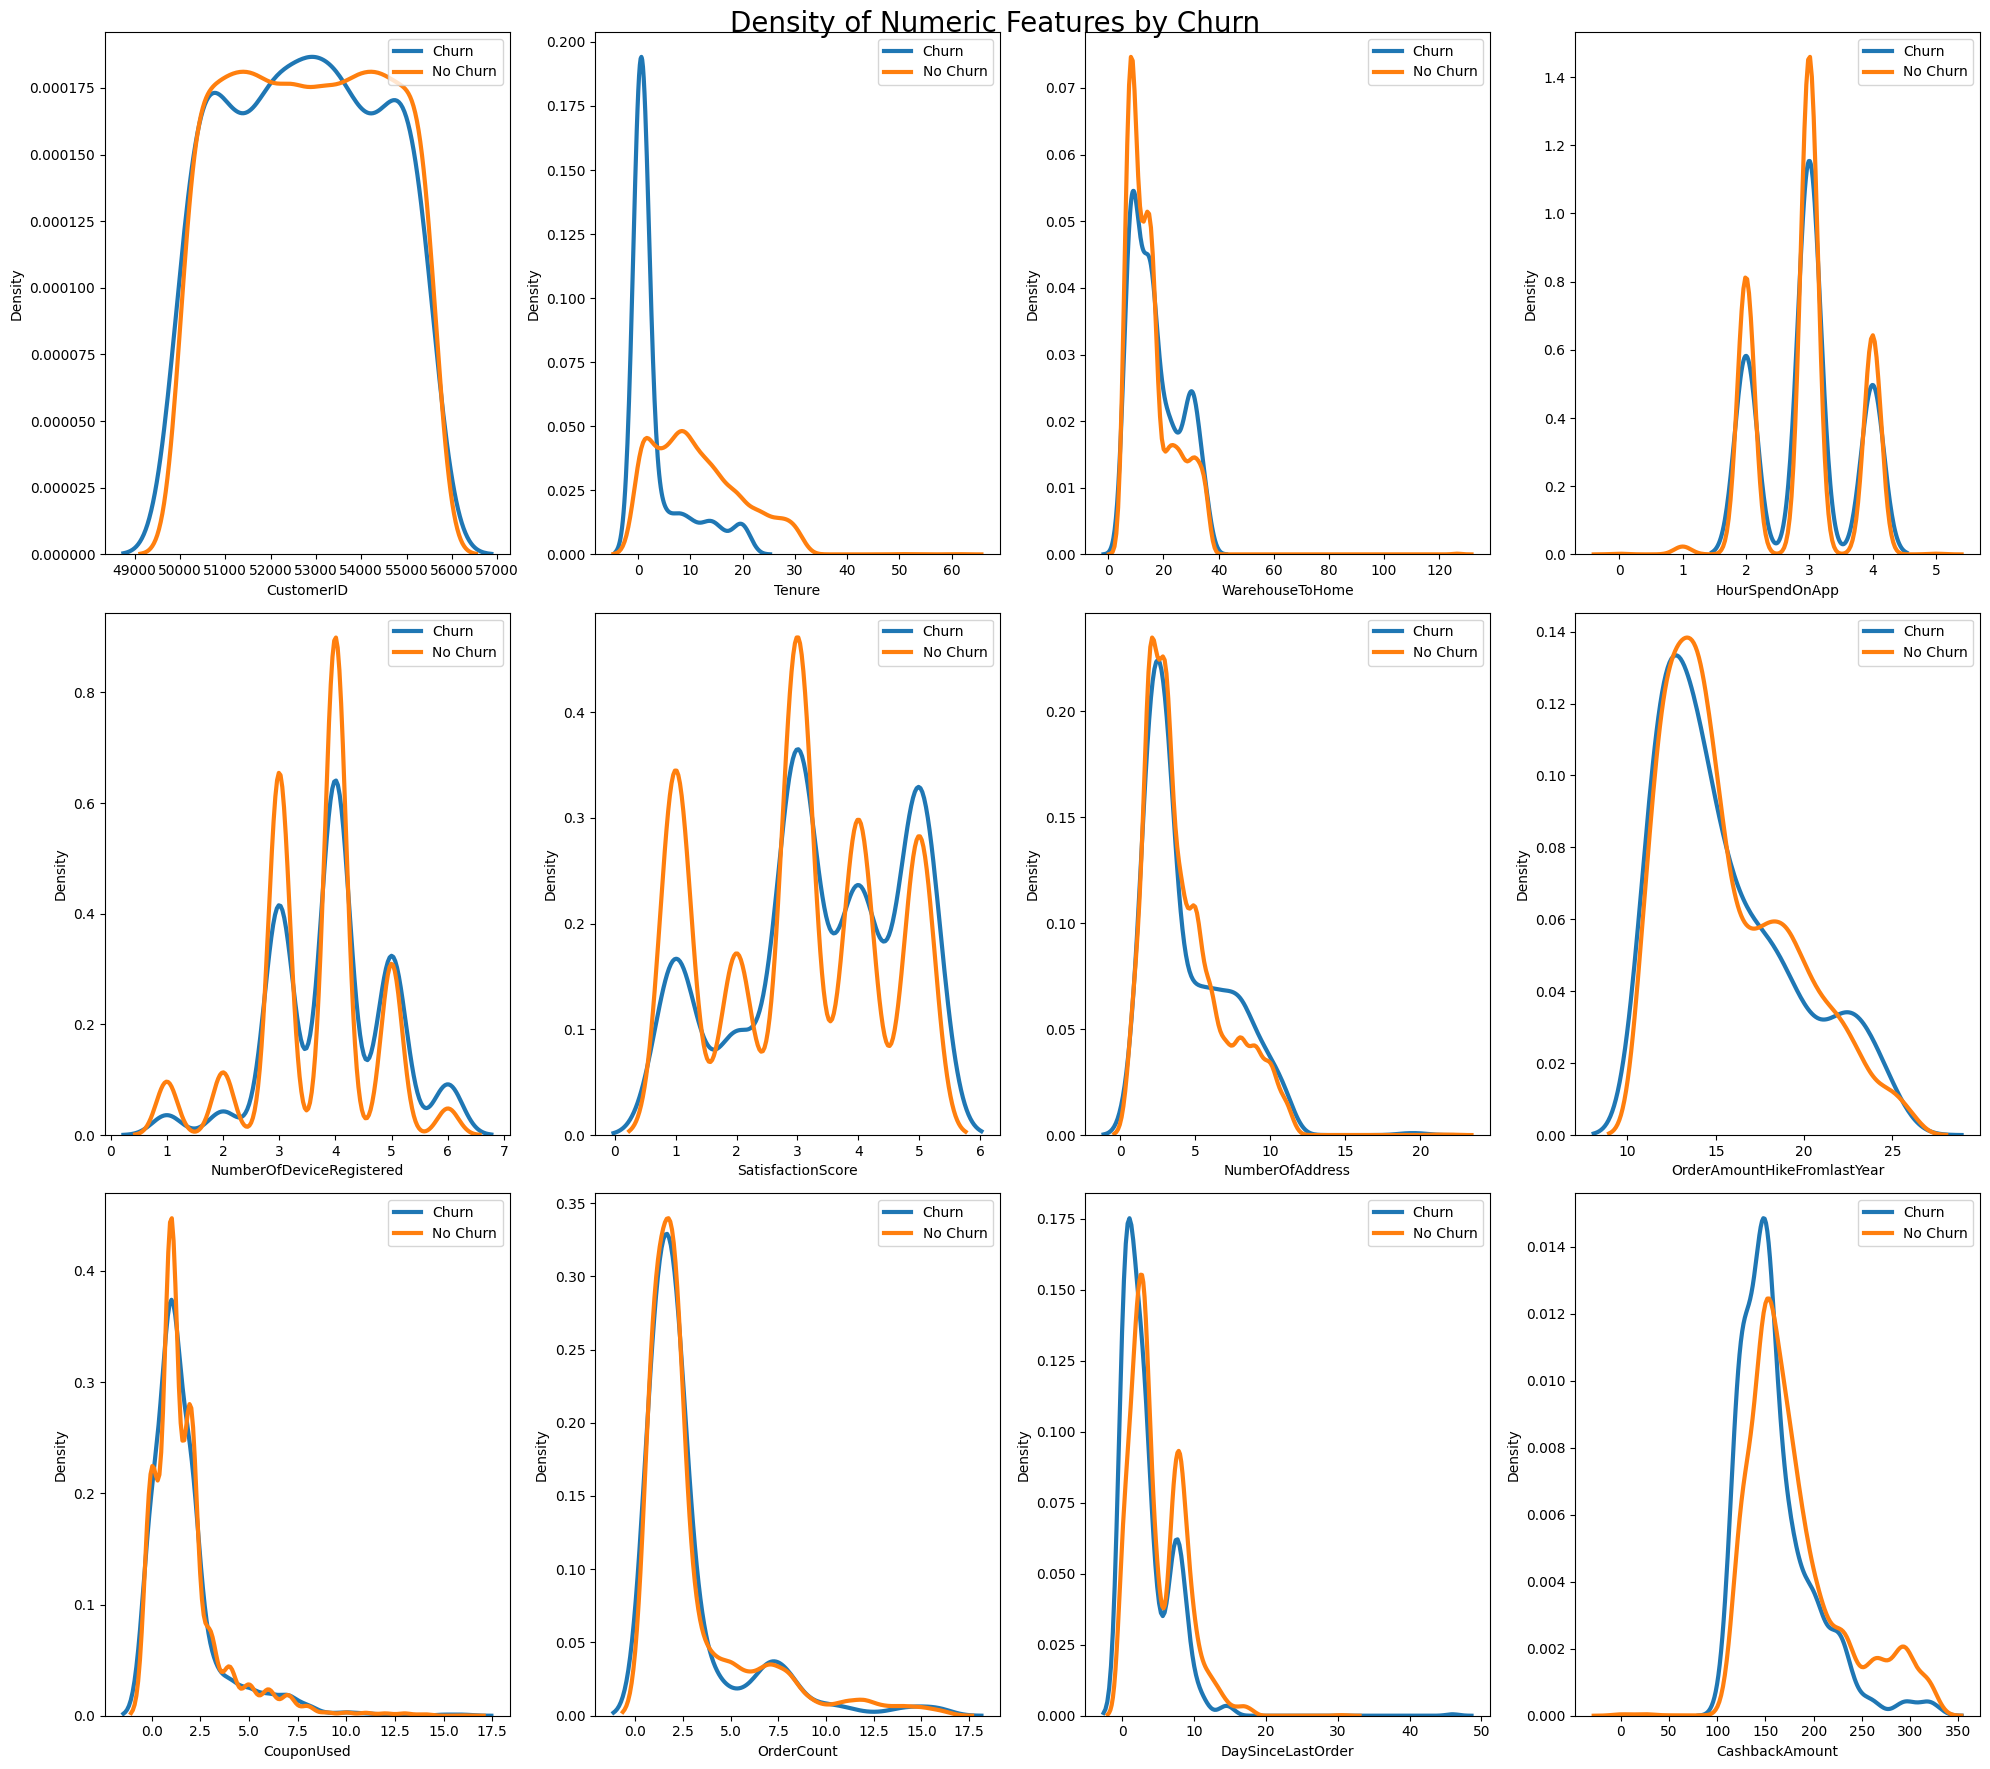

In [17]:
# Visulize density of numeric features by churn
n = len(num)  # number of features
cols = int(np.ceil(np.sqrt(n)))  # number of subplot columns
rows = int(np.ceil(n / cols))  # number of subplot rows

df_c = df[df['Churn']==1].copy()
df_nc = df[df['Churn']==0].copy()

fig, ax = plt.subplots(rows, cols, figsize=(20, 18))
fig.suptitle('Density of Numeric Features by Churn', fontsize=20)
ax = ax.flatten()

for idx, c in enumerate(num):
    sns.kdeplot(df_c[c], linewidth= 3, label = 'Churn',ax=ax[idx])
    sns.kdeplot(df_nc[c], linewidth= 3, label = 'No Churn',ax=ax[idx])
    ax[idx].legend(loc='upper right')

# Remove extra subplots
if n < len(ax):
    for i in range(n, len(ax)):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

--Data Preprocessing 

In [18]:
df.shape

(5630, 20)

In [19]:
df.CustomerID.nunique()

5630

In [20]:
df.duplicated().sum()

0

In [21]:
df.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [22]:
df.isnull().sum().sum()

1856

In [23]:
df[df.isnull().any(axis=1)].shape[0]

1856

In [24]:
# Handling Missing Values

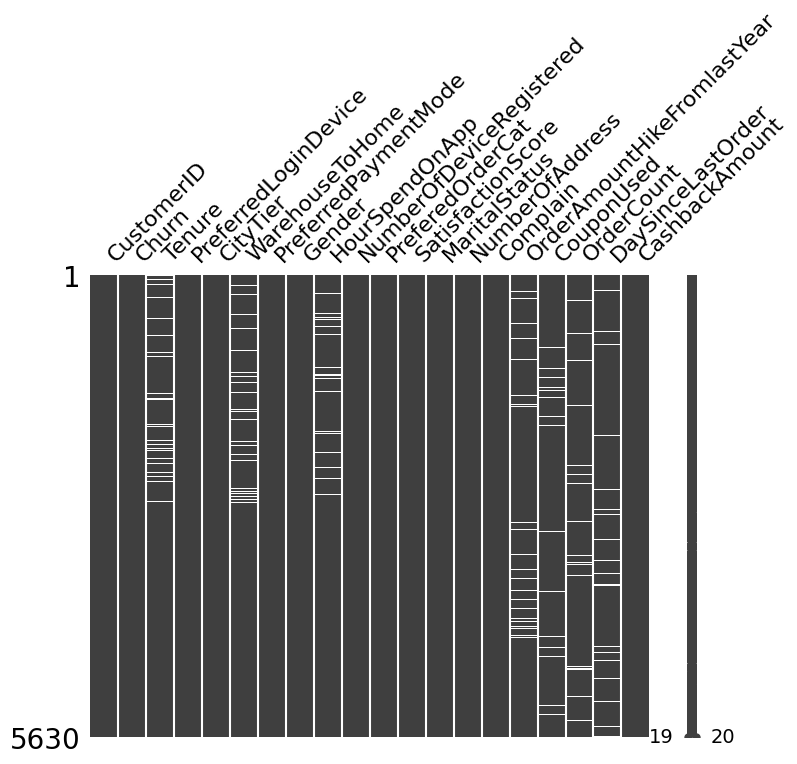

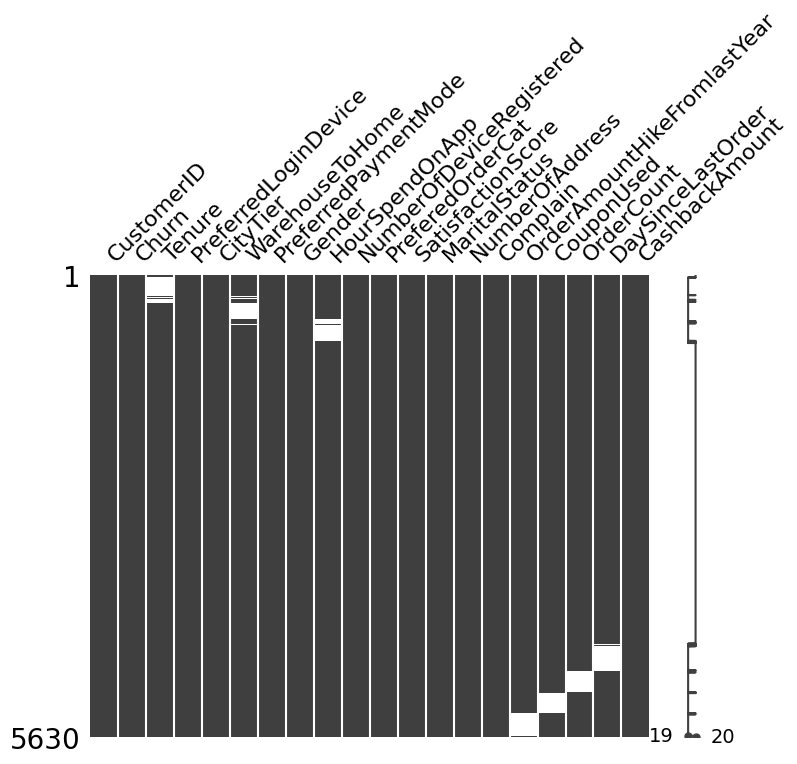

In [25]:
msno.matrix(df, figsize=(8,6))
plt.show()
msno.matrix(df.sort_values(by='CashbackAmount'), figsize=(8,6))
plt.show()
# sorting by the CashbackAmount columns creates a pattern between the missing values and the CashbackAmount columns, which identifies the missingness as missing at random(MAR)

In [26]:
# Perform Little's MCAR test - This test provides a p-value that can help you determine whether your data is likely to be MCAR. If the p-value is below a significance threshold (e.g., 0.05), you can reject the null hypothesis that the data is MCAR.

In [27]:
# Replace non-numeric categorical variables with their codes - LABEL ENCODING
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes
# rpy2 libraries
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import globalenv

# Import R's base package
base = importr("base")

# Import R's utility packages
utils = importr("utils")

# Select mirror 
utils.chooseCRANmirror(ind=1)

# For automatic translation of Pandas objects to R
pandas2ri.activate()

# Enable R magic
%load_ext rpy2.ipython

# Make your Pandas dataframe accessible to R
globalenv["r_df"] = df

utils.install_packages("remotes")
%R remotes::install_github("njtierney/naniar")

%R library(naniar)

# mcar_test on whole df
%R mcar_test(r_df)

R[write to console]: Installing package into 'C:/Users/Uchenna/Documents/R/win-library/4.1'
(as 'lib' is unspecified)

R[write to console]: trying URL 'https://cloud.r-project.org/bin/windows/contrib/4.1/remotes_2.4.2.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 399141 bytes (389 KB)

R[write to console]: downloaded 389 KB




package 'remotes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Uchenna\AppData\Local\Temp\RtmpIjcVsR\downloaded_packages


R[write to console]: Skipping install of 'naniar' from a github remote, the SHA1 (6d335d9d) has not changed since last install.
  Use `force = TRUE` to force installation



,statistic,df,p.value,missing.patterns
1,7609.930823,133.0,0.0,8


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int8   
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   int8   
 4   CityTier                     5630 non-null   int8   
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   int8   
 7   Gender                       5630 non-null   int8   
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   int8   
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   int8   
 13  NumberOfAddress   

In [29]:
df.isnull().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [30]:
df.head(30)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,1,2,6.0,2,0,3.0,3,2,2,2,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,2,0,8.0,4,1,3.0,4,3,3,2,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,2,0,30.0,2,1,2.0,4,3,3,2,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,2,2,15.0,2,1,2.0,4,2,5,2,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,2,0,12.0,0,1,NaN,3,3,5,2,3,0,11.0,1.0,1.0,3.0,130
5,50006,1,0.0,0,0,22.0,2,0,3.0,5,4,5,2,2,1,22.0,4.0,6.0,7.0,139
6,50007,1,NaN,2,2,11.0,1,1,2.0,3,2,2,0,4,0,14.0,0.0,1.0,0.0,121
7,50008,1,NaN,2,0,6.0,0,1,3.0,3,3,2,0,3,1,16.0,2.0,2.0,0.0,123
8,50009,1,13.0,2,2,9.0,3,1,NaN,4,3,3,0,2,1,14.0,0.0,1.0,2.0,127
9,50010,1,NaN,2,0,31.0,2,1,2.0,5,3,3,2,2,0,12.0,1.0,1.0,1.0,123


In [31]:
# Imputing missing values with Multiple Imputation by Chained Equations (MICE) - assumes that the data are Missing At Random (MAR)
imp = IterativeImputer(max_iter=10, random_state=0)

# 'df' is the  DataFrame and 'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder' are the columns with missing values.
# We are imputing values for these seven columns
df[['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']] = imp.fit_transform(df[['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']])

In [32]:
df.head(30)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.000000,1,2,6.000000,2,0,3.000000,3,2,2,2,9,1,11.000000,1.0,1.0,5.0,160
1,50002,1,8.173019,2,0,8.000000,4,1,3.000000,4,3,3,2,7,1,15.000000,0.0,1.0,0.0,121
2,50003,1,8.941634,2,0,30.000000,2,1,2.000000,4,3,3,2,6,1,14.000000,0.0,1.0,3.0,120
3,50004,1,0.000000,2,2,15.000000,2,1,2.000000,4,2,5,2,8,0,23.000000,0.0,1.0,3.0,134
4,50005,1,0.000000,2,0,12.000000,0,1,2.806963,3,3,5,2,3,0,11.000000,1.0,1.0,3.0,130
5,50006,1,0.000000,0,0,22.000000,2,0,3.000000,5,4,5,2,2,1,22.000000,4.0,6.0,7.0,139
6,50007,1,8.422202,2,2,11.000000,1,1,2.000000,3,2,2,0,4,0,14.000000,0.0,1.0,0.0,121
7,50008,1,8.573248,2,0,6.000000,0,1,3.000000,3,3,2,0,3,1,16.000000,2.0,2.0,0.0,123
8,50009,1,13.000000,2,2,9.000000,3,1,2.719642,4,3,3,0,2,1,14.000000,0.0,1.0,2.0,127
9,50010,1,8.285707,2,0,31.000000,2,1,2.000000,5,3,3,2,2,0,12.000000,1.0,1.0,1.0,123


In [33]:
df.isnull().sum()

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

--Handling the Outliers

In [34]:
# List of numeric columns (numeric columns with no categorical numeric codes)
num_columns = ['Tenure','WarehouseToHome','HourSpendOnApp','NumberOfDeviceRegistered','SatisfactionScore','NumberOfAddress','OrderAmountHikeFromlastYear','CouponUsed','OrderCount','DaySinceLastOrder','CashbackAmount']


# Iterate over the list of columns
for column in num_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outliers
    outliers = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
    
    # Drop outliers
    df = df[~outliers]


In [35]:
df.head(30)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.000000,1,2,6.000000,2,0,3.000000,3,2,2,2,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,8.173019,2,0,8.000000,4,1,3.000000,4,3,3,2,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,8.941634,2,0,30.000000,2,1,2.000000,4,3,3,2,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.000000,2,2,15.000000,2,1,2.000000,4,2,5,2,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.000000,2,0,12.000000,0,1,2.806963,3,3,5,2,3,0,11.0,1.0,1.0,3.0,130
6,50007,1,8.422202,2,2,11.000000,1,1,2.000000,3,2,2,0,4,0,14.0,0.0,1.0,0.0,121
7,50008,1,8.573248,2,0,6.000000,0,1,3.000000,3,3,2,0,3,1,16.0,2.0,2.0,0.0,123
8,50009,1,13.000000,2,2,9.000000,3,1,2.719642,4,3,3,0,2,1,14.0,0.0,1.0,2.0,127
9,50010,1,8.285707,2,0,31.000000,2,1,2.000000,5,3,3,2,2,0,12.0,1.0,1.0,1.0,123
11,50012,1,11.000000,1,0,6.000000,2,1,3.000000,4,0,3,2,10,1,13.0,0.0,1.0,0.0,154


Text(0, 0.5, 'Values')

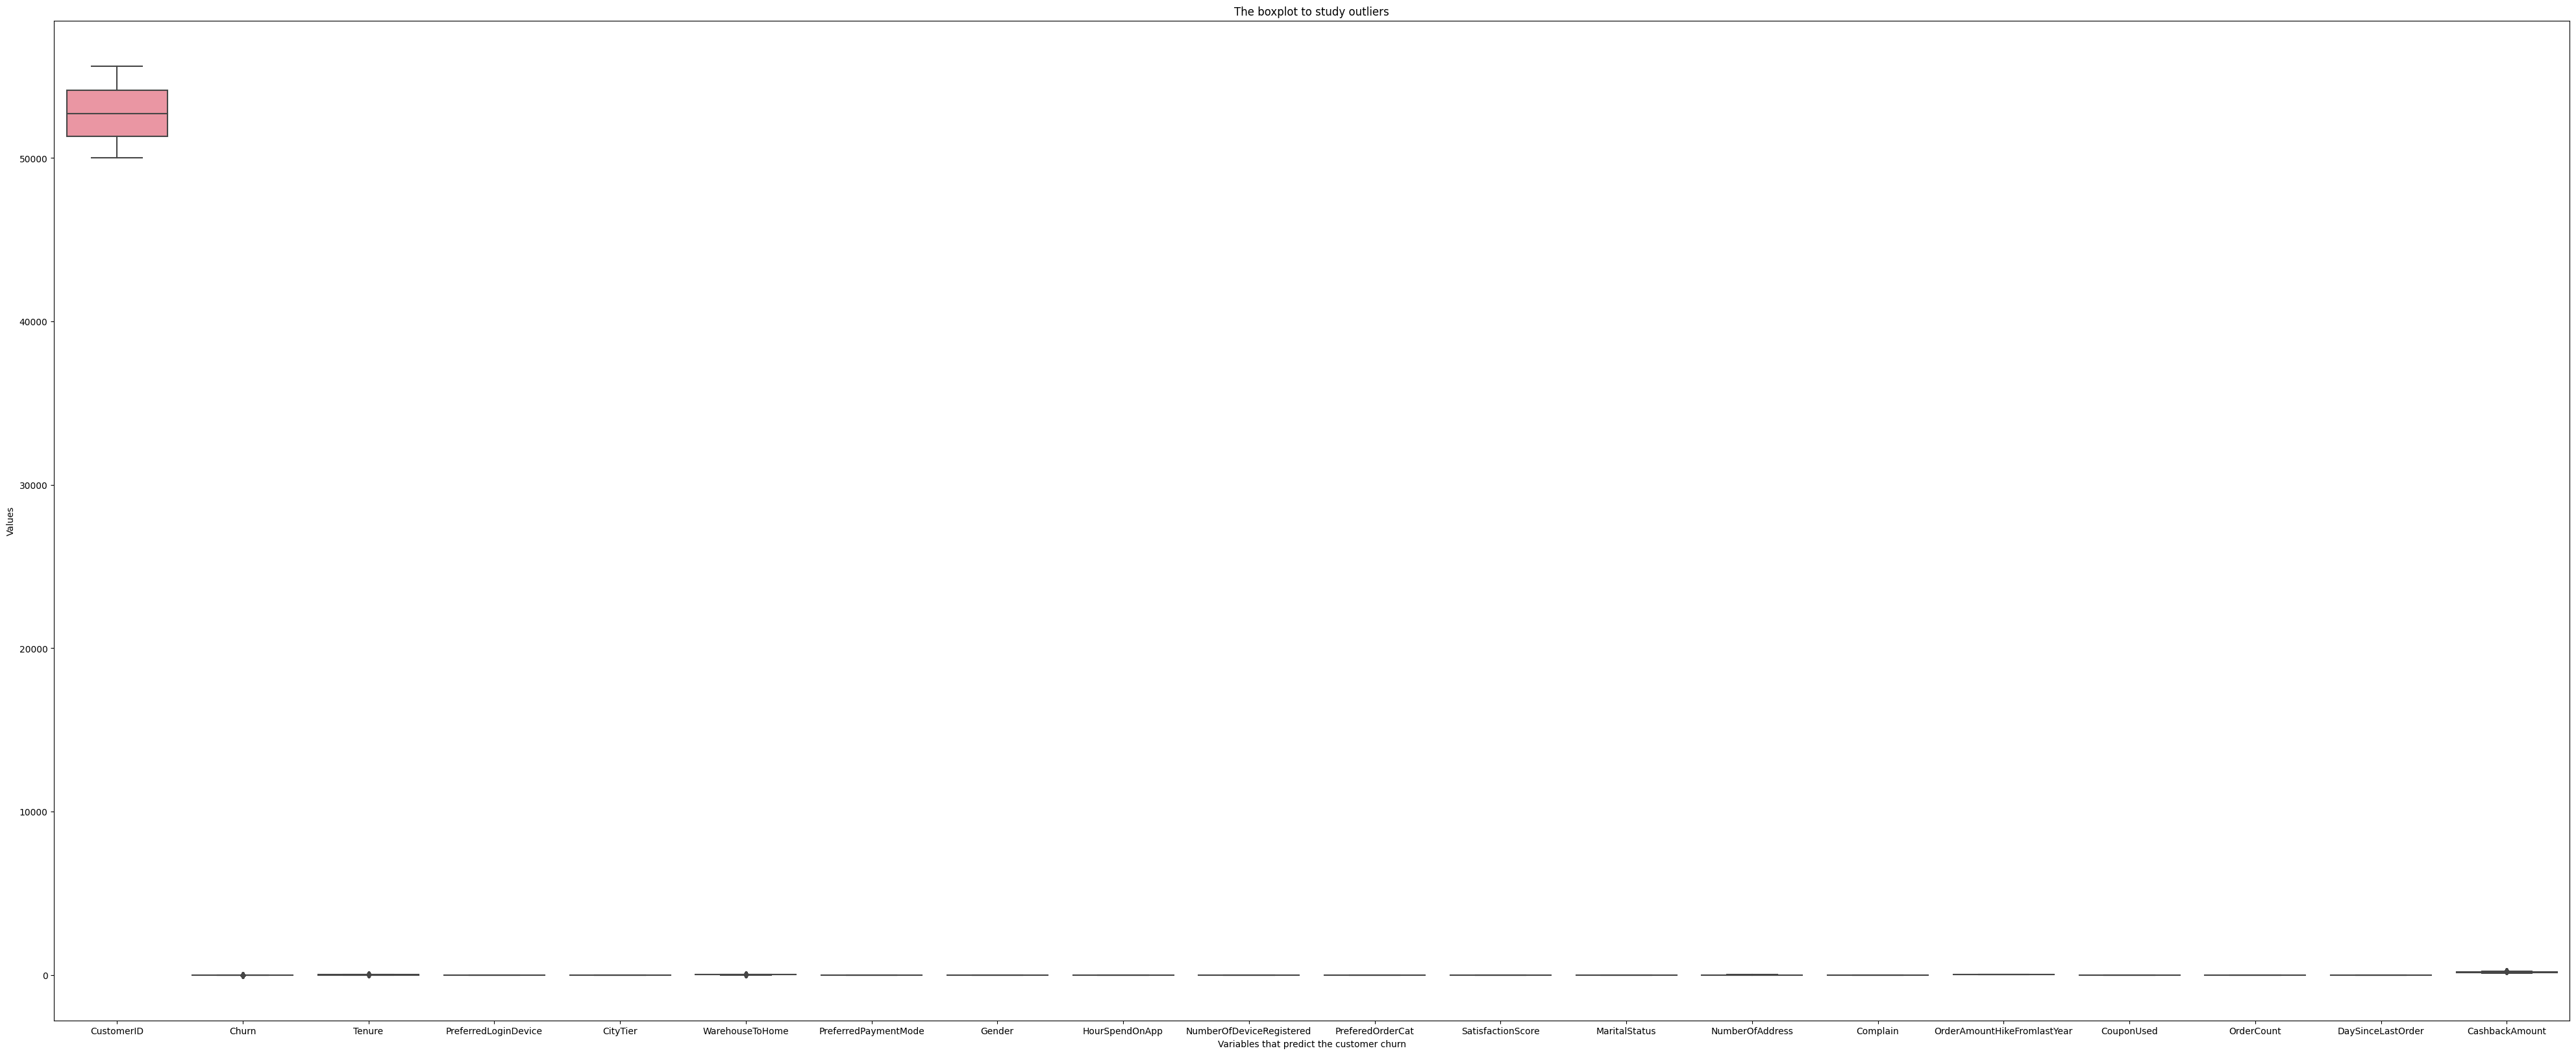

In [36]:
plt.figure(figsize=(50,20))
sns.boxplot(data=df)
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the customer churn')
plt.ylabel('Values')

--Feature Engineering - New Feature Creation

In [37]:
# Create 'AvgCashback' feature
df['AvgCashback'] = df['CashbackAmount'] / df['Tenure']

# Create 'DevicePerAddress' feature
df['DevicePerAddress'] = df['NumberOfDeviceRegistered'] / df['NumberOfAddress']

# Create 'OrderFrequency' feature
df['OrderFrequency'] = df['OrderCount'] / df['Tenure']

# For values NaN values that result from division by 0 ( 'Tenure' is 0, it means the customer has just started or has been with the company for less than a full month) - replace with predictive imputation KNNImputer
# Define columns to impute
cols_to_impute = ['AvgCashback', 'DevicePerAddress', 'OrderFrequency']

# Replace 'inf' and '-inf' with 'NaN' in the specified columns
df[cols_to_impute] = df[cols_to_impute].replace([np.inf, -np.inf], np.nan)

# Create imputer object
imputer = KNNImputer(n_neighbors=5)

# Fit on the data and transform the specified columns
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [38]:
df.head(30)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,AvgCashback,DevicePerAddress,OrderFrequency
0,50001,1,4.000000,1,2,6.000000,2,0,3.000000,3,...,9,1,11.0,1.0,1.0,5.0,160,40.000000,0.333333,0.250000
1,50002,1,8.173019,2,0,8.000000,4,1,3.000000,4,...,7,1,15.0,0.0,1.0,0.0,121,14.804810,0.571429,0.122354
2,50003,1,8.941634,2,0,30.000000,2,1,2.000000,4,...,6,1,14.0,0.0,1.0,3.0,120,13.420365,0.666667,0.111836
3,50004,1,0.000000,2,2,15.000000,2,1,2.000000,4,...,8,0,23.0,0.0,1.0,3.0,134,64.981667,0.500000,1.090000
4,50005,1,0.000000,2,0,12.000000,0,1,2.806963,3,...,3,0,11.0,1.0,1.0,3.0,130,46.634872,1.000000,0.604829
6,50007,1,8.422202,2,2,11.000000,1,1,2.000000,3,...,4,0,14.0,0.0,1.0,0.0,121,14.366789,0.750000,0.118734
7,50008,1,8.573248,2,0,6.000000,0,1,3.000000,3,...,3,1,16.0,2.0,2.0,0.0,123,14.346954,1.000000,0.233284
8,50009,1,13.000000,2,2,9.000000,3,1,2.719642,4,...,2,1,14.0,0.0,1.0,2.0,127,9.769231,2.000000,0.076923
9,50010,1,8.285707,2,0,31.000000,2,1,2.000000,5,...,2,0,12.0,1.0,1.0,1.0,123,14.844840,2.500000,0.120690
11,50012,1,11.000000,1,0,6.000000,2,1,3.000000,4,...,10,1,13.0,0.0,1.0,0.0,154,14.000000,0.400000,0.090909


--ONE HOT ENCODING

In [39]:
df_encoded=df.copy()
df_encoded = pd.get_dummies(df, columns=['Churn', 'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus', 'Complain'])


In [40]:
df.isnull().sum()

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
AvgCashback                    0
DevicePerAddress               0
OrderFrequency                 0
dtype: int64

In [41]:
df.head(30)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,AvgCashback,DevicePerAddress,OrderFrequency
0,50001,1,4.000000,1,2,6.000000,2,0,3.000000,3,...,9,1,11.0,1.0,1.0,5.0,160,40.000000,0.333333,0.250000
1,50002,1,8.173019,2,0,8.000000,4,1,3.000000,4,...,7,1,15.0,0.0,1.0,0.0,121,14.804810,0.571429,0.122354
2,50003,1,8.941634,2,0,30.000000,2,1,2.000000,4,...,6,1,14.0,0.0,1.0,3.0,120,13.420365,0.666667,0.111836
3,50004,1,0.000000,2,2,15.000000,2,1,2.000000,4,...,8,0,23.0,0.0,1.0,3.0,134,64.981667,0.500000,1.090000
4,50005,1,0.000000,2,0,12.000000,0,1,2.806963,3,...,3,0,11.0,1.0,1.0,3.0,130,46.634872,1.000000,0.604829
6,50007,1,8.422202,2,2,11.000000,1,1,2.000000,3,...,4,0,14.0,0.0,1.0,0.0,121,14.366789,0.750000,0.118734
7,50008,1,8.573248,2,0,6.000000,0,1,3.000000,3,...,3,1,16.0,2.0,2.0,0.0,123,14.346954,1.000000,0.233284
8,50009,1,13.000000,2,2,9.000000,3,1,2.719642,4,...,2,1,14.0,0.0,1.0,2.0,127,9.769231,2.000000,0.076923
9,50010,1,8.285707,2,0,31.000000,2,1,2.000000,5,...,2,0,12.0,1.0,1.0,1.0,123,14.844840,2.500000,0.120690
11,50012,1,11.000000,1,0,6.000000,2,1,3.000000,4,...,10,1,13.0,0.0,1.0,0.0,154,14.000000,0.400000,0.090909


--FEATURE SCALING

In [42]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit and transform the data
features = df_encoded[num]
features = scaler.fit_transform(features)
scaled_df_encoded = df_encoded.copy()
scaled_df_encoded[num] = features
scaled_df_encoded.head(10)

,CustomerID,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,OrderAmountHikeFromlastYear,CouponUsed,...,PreferedOrderCat_0,PreferedOrderCat_1,PreferedOrderCat_2,PreferedOrderCat_3,PreferedOrderCat_4,MaritalStatus_0,MaritalStatus_1,MaritalStatus_2,Complain_0,Complain_1
0,-1.680246,-0.567795,2,-1.215786,0.108945,-0.912988,-0.790737,1.842376,-1.321460,-0.113534,...,False,False,True,False,False,False,False,True,False,True
1,-1.679634,-0.016080,0,-0.958626,0.108945,0.343848,-0.060116,1.065618,-0.182276,-1.384444,...,False,False,False,True,False,False,False,True,False,True
2,-1.679022,0.085539,0,1.870130,-1.323452,0.343848,-0.060116,0.677239,-0.467072,-1.384444,...,False,False,False,True,False,False,False,True,False,True
3,-1.678410,-1.096635,2,-0.058567,-1.323452,0.343848,1.401126,1.453997,2.096091,-1.384444,...,False,False,True,False,False,False,False,True,True,False
4,-1.677798,-1.096635,0,-0.444307,-0.167560,-0.912988,1.401126,-0.487899,-1.321460,-0.113534,...,False,False,False,True,False,False,False,True,True,False
6,-1.676573,0.016864,2,-0.572887,-1.323452,-0.912988,-0.790737,-0.099520,-0.467072,-1.384444,...,False,False,True,False,False,True,False,False,True,False
7,-1.675961,0.036834,0,-1.215786,0.108945,-0.912988,-0.790737,-0.487899,0.102520,1.157376,...,False,False,False,True,False,True,False,False,False,True
8,-1.675349,0.622095,2,-0.830046,-0.292639,0.343848,-0.060116,-0.876279,-0.467072,-1.384444,...,False,False,False,True,False,True,False,False,False,True
9,-1.674737,-0.001182,0,1.998710,-1.323452,1.600683,-0.060116,-0.876279,-1.036664,-0.113534,...,False,False,False,True,False,False,False,True,True,False
11,-1.673513,0.357675,0,-1.215786,0.108945,0.343848,-0.060116,2.230756,-0.751868,-1.384444,...,True,False,False,False,False,False,False,True,False,True


In [43]:
scaled_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3403 entries, 0 to 5629
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   3403 non-null   float64
 1   Tenure                       3403 non-null   float64
 2   CityTier                     3403 non-null   int8   
 3   WarehouseToHome              3403 non-null   float64
 4   HourSpendOnApp               3403 non-null   float64
 5   NumberOfDeviceRegistered     3403 non-null   float64
 6   SatisfactionScore            3403 non-null   float64
 7   NumberOfAddress              3403 non-null   float64
 8   OrderAmountHikeFromlastYear  3403 non-null   float64
 9   CouponUsed                   3403 non-null   float64
 10  OrderCount                   3403 non-null   float64
 11  DaySinceLastOrder            3403 non-null   float64
 12  CashbackAmount               3403 non-null   float64
 13  AvgCashback            

--MACHINE LEARNING MODELING

In [46]:
# Define the models
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Stochastic Gradient Descent', SGDClassifier(random_state=42)),
    ('Support Vector Machines', SVC(random_state=42)),
    ('Linear SVC', LinearSVC(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gradient Boosting Classifier', GradientBoostingClassifier(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Neural Networks', MLPClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42))
]

# Split your data
X = scaled_df_encoded.drop(['Churn_0', 'Churn_1'], axis=1)
y = scaled_df_encoded['Churn_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit, predict, and print the classification report for each model
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("------------------------------------------------------")

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       False       0.88      0.95      0.92       538
        True       0.74      0.52      0.61       143

    accuracy                           0.86       681
   macro avg       0.81      0.74      0.77       681
weighted avg       0.85      0.86      0.85       681

------------------------------------------------------
Classification Report for Stochastic Gradient Descent:
              precision    recall  f1-score   support

       False       0.80      0.99      0.89       538
        True       0.70      0.10      0.17       143

    accuracy                           0.80       681
   macro avg       0.75      0.54      0.53       681
weighted avg       0.78      0.80      0.74       681

------------------------------------------------------
Classification Report for Support Vector Machines:
              precision    recall  f1-score   support

       False       0.79     

In [47]:
print(y_train.value_counts())

Churn_1
False    2189
True      533
Name: count, dtype: int64


--HYPERPARAMETER OPTIMIZATION

In [49]:
# Logistic Regression
# Specify the hyperparameters and their values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize a Logistic Regression model
logreg = LogisticRegression()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data and find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred = best_model.predict(X_test)

# Print the new classification report
print(classification_report(y_test, y_pred))


{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

       False       0.88      0.96      0.92       538
        True       0.76      0.50      0.60       143

    accuracy                           0.86       681
   macro avg       0.82      0.73      0.76       681
weighted avg       0.85      0.86      0.85       681



In [51]:
# Linear SVC
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict on the test data
y_pred = grid_search.predict(X_test)

# Print the classification report
print("Classification Report for Optimized Linear SVC:")
print(classification_report(y_test, y_pred))

Best parameters:  {'C': 0.01}
Classification Report for Optimized Linear SVC:
              precision    recall  f1-score   support

       False       0.87      0.96      0.91       538
        True       0.75      0.45      0.57       143

    accuracy                           0.85       681
   macro avg       0.81      0.71      0.74       681
weighted avg       0.84      0.85      0.84       681



In [52]:
# Random Forest
# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10, 15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt']}

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict on the test data
y_pred = grid_search.predict(X_test)

# Print the classification report
print("Classification Report for Optimized Random Forest:")
print(classification_report(y_test, y_pred))

Best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Classification Report for Optimized Random Forest:
              precision    recall  f1-score   support

       False       0.94      0.99      0.97       538
        True       0.97      0.78      0.86       143

    accuracy                           0.95       681
   macro avg       0.96      0.89      0.92       681
weighted avg       0.95      0.95      0.95       681



In [53]:
# K-Nearest Neighbors
# Define the parameter grid
param_grid = {'n_neighbors': list(range(1, 31)),
              'weights': ['uniform', 'distance']}

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict on the test data
y_pred = grid_search.predict(X_test)

# Print the classification report
print("Classification Report for Optimized K-Nearest Neighbors:")
print(classification_report(y_test, y_pred))

Best parameters:  {'n_neighbors': 1, 'weights': 'uniform'}
Classification Report for Optimized C:
              precision    recall  f1-score   support

       False       0.97      0.98      0.98       538
        True       0.93      0.89      0.91       143

    accuracy                           0.96       681
   macro avg       0.95      0.94      0.94       681
weighted avg       0.96      0.96      0.96       681



In [54]:
# Gradient Boosting Classifier
# Define the parameter grid
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [3, 4, 5]}

# Initialize the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

# Predict on the test data
y_pred = grid_search.predict(X_test)

# Print the classification report
print("Classification Report for Optimized Gradient Boosting Classifier:")
print(classification_report(y_test, y_pred))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Classification Report for Optimized Gradient Boosting Classifier:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98       538
        True       0.95      0.88      0.91       143

    accuracy                           0.96       681
   macro avg       0.96      0.93      0.95       681
weighted avg       0.96      0.96      0.96       681



In [55]:
# Neural Networks
# Define the parameter values that should be searched
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive'],
              'learning_rate_init': [0.001, 0.01, 0.1]}

# Create a GridSearchCV object
grid = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=10, scoring='accuracy')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the optimal parameters
print("Best parameters set found on development set:")
print(grid.best_params_)

# Predict on the test data
y_pred = grid.predict(X_test)

# Print the classification report
print("Classification Report for Optimized MLPClassifier:")
print(classification_report(y_test, y_pred))

Best parameters set found on development set:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'}
Classification Report for Optimized MLPClassifier:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       538
        True       0.93      0.84      0.88       143

    accuracy                           0.95       681
   macro avg       0.94      0.91      0.93       681
weighted avg       0.95      0.95      0.95       681



In [56]:
# Decision Tree
# Define the parameter values that should be searched
param_grid = {'max_depth': list(range(1, 21)),
              'min_samples_split': list(range(2, 21)),
              'min_samples_leaf': list(range(1, 21))}

# Create a GridSearchCV object
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, scoring='accuracy')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the optimal parameters
print("Best parameters set found on development set:")
print(grid.best_params_)

# Predict on the test data
y_pred = grid.predict(X_test)

# Print the classification report
print("Classification Report for Optimized Decision Tree:")
print(classification_report(y_test, y_pred))

Best parameters set found on development set:
{'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report for Optimized Decision Tree:
              precision    recall  f1-score   support

       False       0.96      0.94      0.95       538
        True       0.80      0.84      0.82       143

    accuracy                           0.92       681
   macro avg       0.88      0.89      0.88       681
weighted avg       0.92      0.92      0.92       681



--FEATURE IMPORTANCE

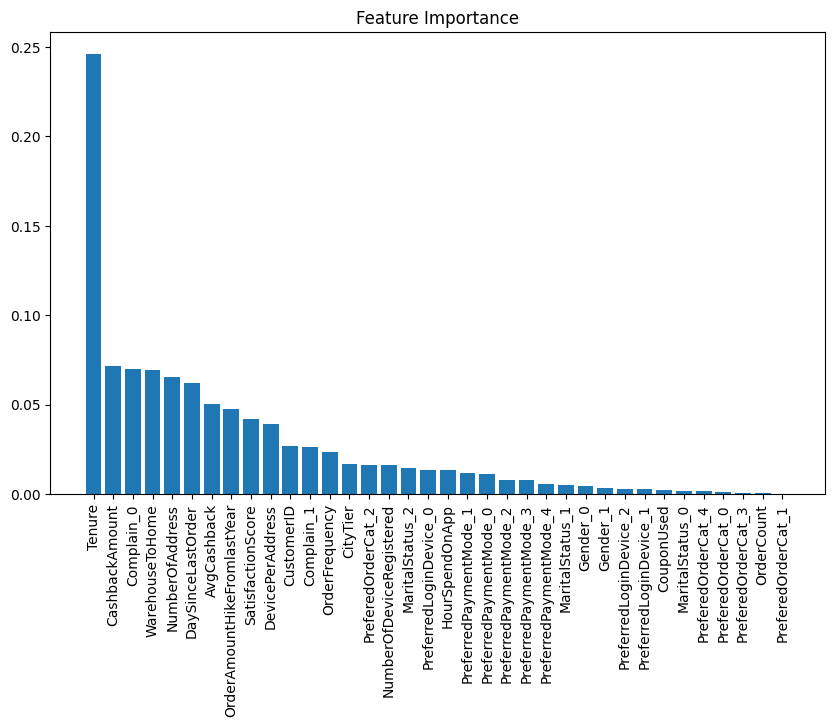

In [57]:
# Feature importance can be analyzed for the Gradient Boosting Classifier (BEST MODEL)
# Fit the model
optimized_parameters = grid_search.best_params_
model = GradientBoostingClassifier(**optimized_parameters)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [ ]:
#  'Tenure', 'Cashbackamount', and 'Complain_0' being the top three features indicates that these three features have the most significant impact on the model's ability to predict customer churn.